In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Import the data

In [7]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [8]:
df['price']

0        149
1        225
2        150
3         89
4         80
        ... 
48890     70
48891     40
48892    115
48893     55
48894     90
Name: price, Length: 48895, dtype: int64

# Exploratory Data Analysis

<AxesSubplot:xlabel='price', ylabel='Count'>

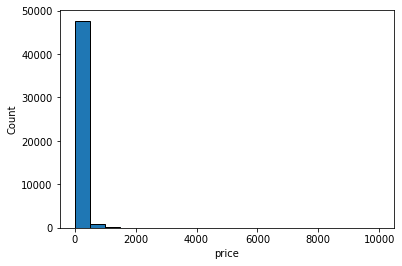

In [9]:
plt.figure(figsize=(6, 4))
sns.histplot(df.price, bins=20, alpha=1)

In [10]:

columns = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 
           'reviews_per_month','calculated_host_listings_count', 'availability_365']
df = df[columns]

<AxesSubplot:xlabel='price', ylabel='Count'>

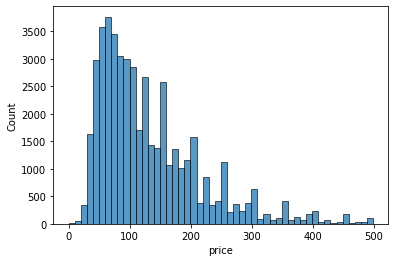

In [11]:
df_price = df[df['price'] < 500]
sns.histplot(df_price['price'], bins=50)

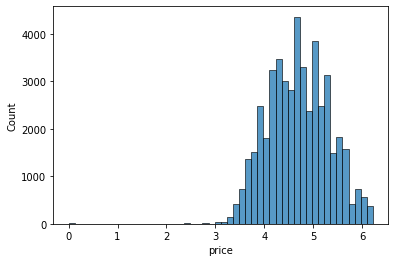

In [12]:
log_price = np.log1p(df_price.price)
sns.histplot(log_price, bins=50)
plt.show()

# Question 1

In [13]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Question 2

In [14]:
df['minimum_nights'].median()

3.0

In [15]:
np.random.seed(42)

In [16]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
n_train, n_val, n_test


(29337, 9779, 9779)

In [18]:
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()


In [19]:
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [20]:
df_train.values.shape

(29337, 7)

In [21]:
mean_reviews_per_month = df['reviews_per_month'].mean()

def prepare_X(df, mean=False):
    df_ret = None
    if not mean:
        df_ret = df.fillna(0)
    else:
        df_ret = df.fillna(mean_reviews_per_month)
    return df_ret.values

f"Mean reviews per month is {mean_reviews_per_month}"

'Mean reviews per month is 1.3732214298586618'

In [22]:
def train_linear_regression(X, y): 
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])  # y = w0 + X*W, this step is for inserting w0 into the W matrix

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]
    

In [23]:
# filling NANs with 0
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
w_0, w

(-417.00823788231787,
 array([ 1.35439542e+00, -4.95624028e+00, -6.78854336e-04, -4.23425239e-04,
        -7.03145572e-03,  1.33203448e-03,  6.10653231e-04]))

In [24]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

In [25]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

# Question 3

In [26]:
round(rmse(y_val, y_pred), 2)

0.65

In [27]:
# filling NANs with mean
X_train = prepare_X(df_train, mean=True)
w_0, w = train_linear_regression(X_train, y_train)
X_val = prepare_X(df_val, mean=True)
y_pred = w_0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.65

In [28]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [29]:
X_train = prepare_X(df_train, mean=False)
X_val = prepare_X(df_val, mean=True)

# Question 4

In [30]:
rmse_values = []
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    error = rmse(y_val, y_pred)
    rmse_values.append((r, error))

rmse_values
    

[(0, 0.6475752827709734),
 (1e-06, 0.6475758433254206),
 (0.0001, 0.6476359164382451),
 (0.001, 0.6485084763029112),
 (0.01, 0.6613856880045864),
 (0.1, 0.6839680525255795),
 (1, 0.6891782099767633),
 (5, 0.6897200347589275),
 (10, 0.6898186298116967)]

# Question 5

In [31]:
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_test - n_test

def get_train_test_validate(df, seed):
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()
    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)
    del df_train['price']
    del df_val['price']
    del df_test['price']
    X_train = prepare_X(df_train, mean=False)
    X_test = prepare_X(df_test, mean=False)
    X_val = prepare_X(df_val, mean=False)
    return (X_train, X_test, X_val), (y_train, y_test, y_val)

In [32]:
result = []
rmse_values = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    X_data, y_data = get_train_test_validate(df, seed)
    w_0, w = train_linear_regression(X_data[0], y_data[0])
    y_pred = w_0 + X_data[2].dot(w) # using validation data
    error = rmse(y_data[2], y_pred)
    result.append((seed, error))
    rmse_values.append(error)
result

[(0, 0.6549779960634078),
 (1, 0.646252368570824),
 (2, 0.6476558176892987),
 (3, 0.6375145070413034),
 (4, 0.6445809083537355),
 (5, 0.6305809995898742),
 (6, 0.6297851917431656),
 (7, 0.6506184266524485),
 (8, 0.6489780353352816),
 (9, 0.6437565168360442)]

In [33]:
f"The standard deviated is {round(np.std(rmse_values), 3)}"

'The standard deviated is 0.008'

# Question 6

In [34]:
seed = 9
r = 0.001
X_data, y_data = get_train_test_validate(df, seed)
X_train, X_test, X_val = X_data
y_train, y_test, y_val = y_data
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
w_0, w = train_linear_regression_reg(X_train_val, y_train_val, r)
y_test_pred = w_0 + X_test.dot(w) # using validation data
rmse(y_test, y_test_pred)

0.6452771348372212